In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime

#datelist = pd.date_range(start = "2015-01-03", end= '2020-01-04', freq = '7D').strftime('%y%m%d')
#datelist = pd.date_range(start = "2019-10-12", end= '2020-01-10', freq = '7D').strftime('%y%m%d')
datelist=list(datelist)
dates = [int(i) for i in datelist]
print(len(dates))
dates

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh as bk
import numpy as np
import pandas as pd
import urllib.request

url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
week_nums = dates

for week_num in week_nums:
    urllib.request.urlretrieve(f"http://web.mta.info/developers/data/nyct/turnstile/turnstile_{week_num}.txt",
                               f"data/turnstile_{week_num}.txt")

In [149]:
import numpy as np
import pandas as pd
import urllib.request
import sqlalchemy as sql

engine = sql.create_engine("sqlite:///mta_bigdata.db")
mta_data1 = pd.read_sql('SELECT * FROM year2;', engine)
mta_data2 = pd.read_sql('SELECT * FROM year3;', engine)
mta_data3 = pd.read_sql('SELECT * FROM year4;', engine)
mta_data4 = pd.read_sql('SELECT * FROM year5;', engine)
mta_data5 = pd.read_sql('SELECT * FROM year6;', engine)


In [150]:
import datetime
def my_algo(data):
    #droping the first row because it is just a repeat of the column names
    data.drop(0, inplace=True)
    
    #changing the entries and exits type from str to ints so I can perfor operations and aggregations on
    data['ENTRIES']= data['ENTRIES'].astype(str).astype(int)
    data['EXITS']= data['EXITS'].astype(str).astype(int)
    
    #stripping or preceding an or receding spaces that may be around each column
    data.columns = [column.strip() for column in data.columns]
    
    #lets add proper date_time col to the data
    data["DATE_TIME"] = pd.to_datetime(data.DATE + " " + data.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")
    
    #lets combine CA, UNIT, and SCP into turnstile_id , which describes a single turnstile
    data['TURNSTILE_ID'] = data['CA'] + '-' + data['UNIT'] + '-' + data['SCP']
    
    #lets see how our 2 numerical cols look like
    print('entries description')
    print(data['ENTRIES'].describe())
    print('____________')
    print('exits description')
    print(data['EXITS'].describe())
    
    #just in case
    data.fillna(0,inplace=True)
    
    data = data[['TURNSTILE_ID', 'CA','UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION','DATE','TIME', 'DESC', 'ENTRIES', 'EXITS', 'DATE_TIME']]
    
    #lets create 2 new entries to give us the net entries and exits
    data['NET_ENTRIES'] = data['ENTRIES'].transform(pd.Series.diff)
    data['NET_EXITS'] = data['EXITS'].transform(pd.Series.diff)
                
    #lets see a few things before
    print(f"Number of negative NET_ENTRIES: {len(data['NET_ENTRIES'][data['NET_ENTRIES'] < 0])}")
    print(f"Number of negative NET_EXITS: {len(data['NET_EXITS'][data['NET_EXITS'] < 0])}")
    print('Number of unqiue turnstiles: %d' %len(data['TURNSTILE_ID'].unique()))
    print('Number of NaN rows: %d' %len(data[data['NET_ENTRIES'].isnull()]))
    print('Number of NaN rows: %d' %len(data[data['NET_EXITS'].isnull()]))
                
    # now lets fill those NaNs with 0
    data['NET_ENTRIES'] = data['NET_ENTRIES'].fillna(0)
    data['NET_EXITS'] = data['NET_EXITS'].fillna(0)

    # there are negative values, fill it with the absolute values
    data['NET_ENTRIES'][data['NET_ENTRIES'] < 0] = np.abs(data.loc[:, ('NET_ENTRIES')])
    data['NET_EXITS'][data['NET_EXITS'] < 0] = np.abs(data.loc[:, ('NET_EXITS')])
    
    #now, for values greater than 6000 which is abnormal, we will replace it with 0
    data['NET_ENTRIES'][data['NET_ENTRIES'] >= 6000] = 0 
    data['NET_EXITS'][data['NET_EXITS'] >= 6000] = 0

    #now lets see what our data looks like after that cleaning
    print(f"Number of negative NET_ENTRIES: {len(data['NET_ENTRIES'][data['NET_ENTRIES'] < 0])}")
    print(f"Number of negative NET_EXITS: {len(data['NET_EXITS'][data['NET_EXITS'] < 0])}")
    print('Number of unqiue turnstiles: %d' %len(data['TURNSTILE_ID'].unique()))
    print('Number of NaN rows: %d' %len(data[data['NET_ENTRIES'].isnull()]))
    print('Number of NaN rows: %d' %len(data[data['NET_EXITS'].isnull()]))
                
    # let's add total trafic column by adding entries and exits 
    data['TOT_IN_OUT'] = data['NET_ENTRIES'].values + data['NET_EXITS'].values
                
    #we now make our final trim of the colums by droping cols we wont need in my analysis. ie DESC, ENTRIES, EXITS
    mta_final = data.drop(['CA',	'UNIT',	'SCP','DESC','LINENAME','DIVISION', 'ENTRIES', 'EXITS'], axis=1)
    return mta_final
                
        
    

In [151]:
mta_data1 = my_algo(mta_data1)
mta_data2 = my_algo(mta_data2)
mta_data3 = my_algo(mta_data3)
mta_data4 = my_algo(mta_data4)
mta_data5 = my_algo(mta_data5)

entries description
count    2.517573e+06
mean     3.283758e+07
std      1.867299e+08
min      0.000000e+00
25%      5.416320e+05
50%      2.422421e+06
75%      6.223891e+06
max      2.114534e+09
Name: ENTRIES, dtype: float64
____________
exits description
count    2.517573e+06
mean     2.689407e+07
std      1.692976e+08
min      0.000000e+00
25%      2.861530e+05
50%      1.433281e+06
75%      4.483853e+06
max      2.087387e+09
Name: EXITS, dtype: float64


<ipython-input-150-1490a72d153a>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NET_ENTRIES'] = data['ENTRIES'].transform(pd.Series.diff)
<ipython-input-150-1490a72d153a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NET_EXITS'] = data['EXITS'].transform(pd.Series.diff)


Number of negative NET_ENTRIES: 46427
Number of negative NET_EXITS: 41916
Number of unqiue turnstiles: 4583
Number of NaN rows: 1
Number of NaN rows: 1


<ipython-input-150-1490a72d153a>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NET_ENTRIES'] = data['NET_ENTRIES'].fillna(0)
<ipython-input-150-1490a72d153a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NET_EXITS'] = data['NET_EXITS'].fillna(0)
<ipython-input-150-1490a72d153a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

Number of negative NET_ENTRIES: 0
Number of negative NET_EXITS: 0
Number of unqiue turnstiles: 4583
Number of NaN rows: 0
Number of NaN rows: 0


<ipython-input-150-1490a72d153a>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TOT_IN_OUT'] = data['NET_ENTRIES'].values + data['NET_EXITS'].values


entries description
count    2.507320e+06
mean     3.584483e+07
std      1.954299e+08
min      0.000000e+00
25%      5.585180e+05
50%      2.663022e+06
75%      6.681340e+06
max      2.114952e+09
Name: ENTRIES, dtype: float64
____________
exits description
count    2.507320e+06
mean     2.892532e+07
std      1.772716e+08
min      0.000000e+00
25%      2.880558e+05
50%      1.544584e+06
75%      4.736820e+06
max      2.087387e+09
Name: EXITS, dtype: float64


<ipython-input-150-1490a72d153a>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NET_ENTRIES'] = data['ENTRIES'].transform(pd.Series.diff)
<ipython-input-150-1490a72d153a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NET_EXITS'] = data['EXITS'].transform(pd.Series.diff)


Number of negative NET_ENTRIES: 48068
Number of negative NET_EXITS: 43321
Number of unqiue turnstiles: 4629
Number of NaN rows: 1
Number of NaN rows: 1


<ipython-input-150-1490a72d153a>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NET_ENTRIES'] = data['NET_ENTRIES'].fillna(0)
<ipython-input-150-1490a72d153a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NET_EXITS'] = data['NET_EXITS'].fillna(0)
<ipython-input-150-1490a72d153a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

Number of negative NET_ENTRIES: 0
Number of negative NET_EXITS: 0
Number of unqiue turnstiles: 4629
Number of NaN rows: 0
Number of NaN rows: 0


<ipython-input-150-1490a72d153a>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TOT_IN_OUT'] = data['NET_ENTRIES'].values + data['NET_EXITS'].values


entries description
count    2.579139e+06
mean     3.980850e+07
std      2.074193e+08
min      0.000000e+00
25%      4.987405e+05
50%      2.675363e+06
75%      6.915308e+06
max      2.130285e+09
Name: ENTRIES, dtype: float64
____________
exits description
count    2.579139e+06
mean     3.249600e+07
std      1.904768e+08
min      0.000000e+00
25%      2.542225e+05
50%      1.486765e+06
75%      4.798883e+06
max      2.140537e+09
Name: EXITS, dtype: float64


<ipython-input-150-1490a72d153a>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NET_ENTRIES'] = data['ENTRIES'].transform(pd.Series.diff)
<ipython-input-150-1490a72d153a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NET_EXITS'] = data['EXITS'].transform(pd.Series.diff)


Number of negative NET_ENTRIES: 52029
Number of negative NET_EXITS: 47562
Number of unqiue turnstiles: 4745
Number of NaN rows: 1
Number of NaN rows: 1


<ipython-input-150-1490a72d153a>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NET_ENTRIES'] = data['NET_ENTRIES'].fillna(0)
<ipython-input-150-1490a72d153a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NET_EXITS'] = data['NET_EXITS'].fillna(0)
<ipython-input-150-1490a72d153a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

Number of negative NET_ENTRIES: 0
Number of negative NET_EXITS: 0
Number of unqiue turnstiles: 4745
Number of NaN rows: 0
Number of NaN rows: 0


<ipython-input-150-1490a72d153a>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TOT_IN_OUT'] = data['NET_ENTRIES'].values + data['NET_EXITS'].values


entries description
count    2.601776e+06
mean     3.917046e+07
std      2.031678e+08
min      0.000000e+00
25%      4.732578e+05
50%      2.424336e+06
75%      6.924610e+06
max      2.129700e+09
Name: ENTRIES, dtype: float64
____________
exits description
count    2.601776e+06
mean     3.265875e+07
std      1.904245e+08
min      0.000000e+00
25%      2.158970e+05
50%      1.378778e+06
75%      4.803051e+06
max      2.062535e+09
Name: EXITS, dtype: float64


<ipython-input-150-1490a72d153a>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NET_ENTRIES'] = data['ENTRIES'].transform(pd.Series.diff)
<ipython-input-150-1490a72d153a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NET_EXITS'] = data['EXITS'].transform(pd.Series.diff)


Number of negative NET_ENTRIES: 51725
Number of negative NET_EXITS: 48335
Number of unqiue turnstiles: 4818
Number of NaN rows: 1
Number of NaN rows: 1


<ipython-input-150-1490a72d153a>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NET_ENTRIES'] = data['NET_ENTRIES'].fillna(0)
<ipython-input-150-1490a72d153a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NET_EXITS'] = data['NET_EXITS'].fillna(0)
<ipython-input-150-1490a72d153a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

Number of negative NET_ENTRIES: 0
Number of negative NET_EXITS: 0
Number of unqiue turnstiles: 4818
Number of NaN rows: 0
Number of NaN rows: 0


<ipython-input-150-1490a72d153a>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TOT_IN_OUT'] = data['NET_ENTRIES'].values + data['NET_EXITS'].values


entries description
count    2.680916e+06
mean     4.175263e+07
std      2.145075e+08
min      0.000000e+00
25%      3.119420e+05
50%      1.980676e+06
75%      6.637321e+06
max      2.129051e+09
Name: ENTRIES, dtype: float64
____________
exits description
count    2.680916e+06
mean     3.423374e+07
std      1.966589e+08
min      0.000000e+00
25%      1.443098e+05
50%      1.170374e+06
75%      4.544166e+06
max      2.123717e+09
Name: EXITS, dtype: float64


<ipython-input-150-1490a72d153a>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NET_ENTRIES'] = data['ENTRIES'].transform(pd.Series.diff)
<ipython-input-150-1490a72d153a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NET_EXITS'] = data['EXITS'].transform(pd.Series.diff)


Number of negative NET_ENTRIES: 55576
Number of negative NET_EXITS: 49277
Number of unqiue turnstiles: 4948
Number of NaN rows: 1
Number of NaN rows: 1


<ipython-input-150-1490a72d153a>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NET_ENTRIES'] = data['NET_ENTRIES'].fillna(0)
<ipython-input-150-1490a72d153a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NET_EXITS'] = data['NET_EXITS'].fillna(0)
<ipython-input-150-1490a72d153a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

Number of negative NET_ENTRIES: 0
Number of negative NET_EXITS: 0
Number of unqiue turnstiles: 4948
Number of NaN rows: 0
Number of NaN rows: 0


<ipython-input-150-1490a72d153a>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TOT_IN_OUT'] = data['NET_ENTRIES'].values + data['NET_EXITS'].values


In [152]:
mta_data5.describe()

,NET_ENTRIES,NET_EXITS,TOT_IN_OUT
count,2.680916e+06,2.680916e+06,2.680916e+06
mean,1.677293e+02,1.357331e+02,3.034623e+02
std,2.617781e+02,2.439332e+02,4.053975e+02
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+00,7.000000e+00,2.600000e+01
50%,6.600000e+01,4.900000e+01,1.540000e+02
75%,2.240000e+02,1.590000e+02,4.310000e+02
max,5.999000e+03,5.997000e+03,1.045300e+04


In [156]:
year1_totals= mta_data1.groupby(['STATION']).sum()
year2_totals= mta_data2.groupby(['STATION']).sum()
year3_totals= mta_data3.groupby(['STATION']).sum()
year4_totals= mta_data4.groupby(['STATION']).sum()
year5_totals= mta_data5.groupby(['STATION']).sum()


In [155]:
(year_totals["NET_ENTRIES"].index)

NameError: name 'year_totals' is not defined

In [ ]:
(year1_totals["NET_ENTRIES"].index)

In [157]:
year1_totals["log_NET_ENTRIES"]= np.log(year1_totals["NET_ENTRIES"])
year1_totals["log_EXITS"]= np.log(year1_totals["NET_EXITS"])
year1_totals

/Users/bernie/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,NET_ENTRIES,NET_EXITS,TOT_IN_OUT,log_NET_ENTRIES,log_EXITS
STATION,,,,,
1 AV,260543.0,284559.0,545102.0,12.470523,12.558696
1 AVE,1676301.0,1741719.0,3418020.0,14.332100,14.370383
103 ST,2624761.0,1899797.0,4524558.0,14.780500,14.457258
103 ST-CORONA,1634154.0,1178193.0,2812347.0,14.306636,13.979492
104 ST,240078.0,130101.0,370179.0,12.388719,11.776066
...,...,...,...,...,...
WOODLAWN ROAD,522762.0,128379.0,651141.0,13.166882,11.762742
WORLD TRADE CTR,1188624.0,610184.0,1798808.0,13.988307,13.321516
YORK ST,721953.0,529063.0,1251016.0,13.489715,13.178863


In [158]:

pd.set_option("plotting.backend", 'pandas_bokeh')

year1_totals.plot_bokeh(kind = 'scatter', x ='NET_ENTRIES', y='NET_EXITS', category = 'TOT_IN_OUT', )
#plt.scatter(yeah1_totals.NET_ENTRIES, yeah1_totals.NET_EXITS)
plt.show()

In [159]:
fst_AV_tot = station_daily['NET_ENTRIES'].sum().loc['1 AV'].sort_index()

NameError: name 'station_daily' is not defined

In [161]:
year1_totals= mta_data1.groupby(['STATION']).sum()
year2_totals= mta_data2.groupby(['STATION']).sum()
year3_totals= mta_data3.groupby(['STATION']).sum()
year4_totals= mta_data4.groupby(['STATION']).sum()
year5_totals= mta_data5.groupby(['STATION']).sum()

In [162]:
Year1 = year1_totals.sort_values(by="NET_ENTRIES", ascending = False).head(10)
Year2 = year2_totals.sort_values(by="NET_ENTRIES", ascending = False).head(10)
Year3 = year3_totals.sort_values(by="NET_ENTRIES", ascending = False).head(10)
Year4 = year4_totals.sort_values(by="NET_ENTRIES", ascending = False).head(10)
Year5 = year5_totals.sort_values(by="NET_ENTRIES", ascending = False).head(10)
Year3

,NET_ENTRIES,NET_EXITS,TOT_IN_OUT
STATION,,,
34 ST-PENN STA,12833146.0,11136211.0,23969357.0
GRD CNTRL-42 ST,11029861.0,10481849.0,21511710.0
34 ST-HERALD SQ,9954329.0,8755813.0,18710142.0
23 ST,8829719.0,6428165.0,15257884.0
14 ST-UNION SQ,8484069.0,7447874.0,15931943.0
TIMES SQ-42 ST,7959910.0,7282666.0,15242576.0
42 ST-PORT AUTH,7832002.0,5962504.0,13794506.0
FULTON ST,7172757.0,5785284.0,12958041.0
86 ST,6798410.0,5690272.0,12488682.0


No handles with labels found to put in legend.


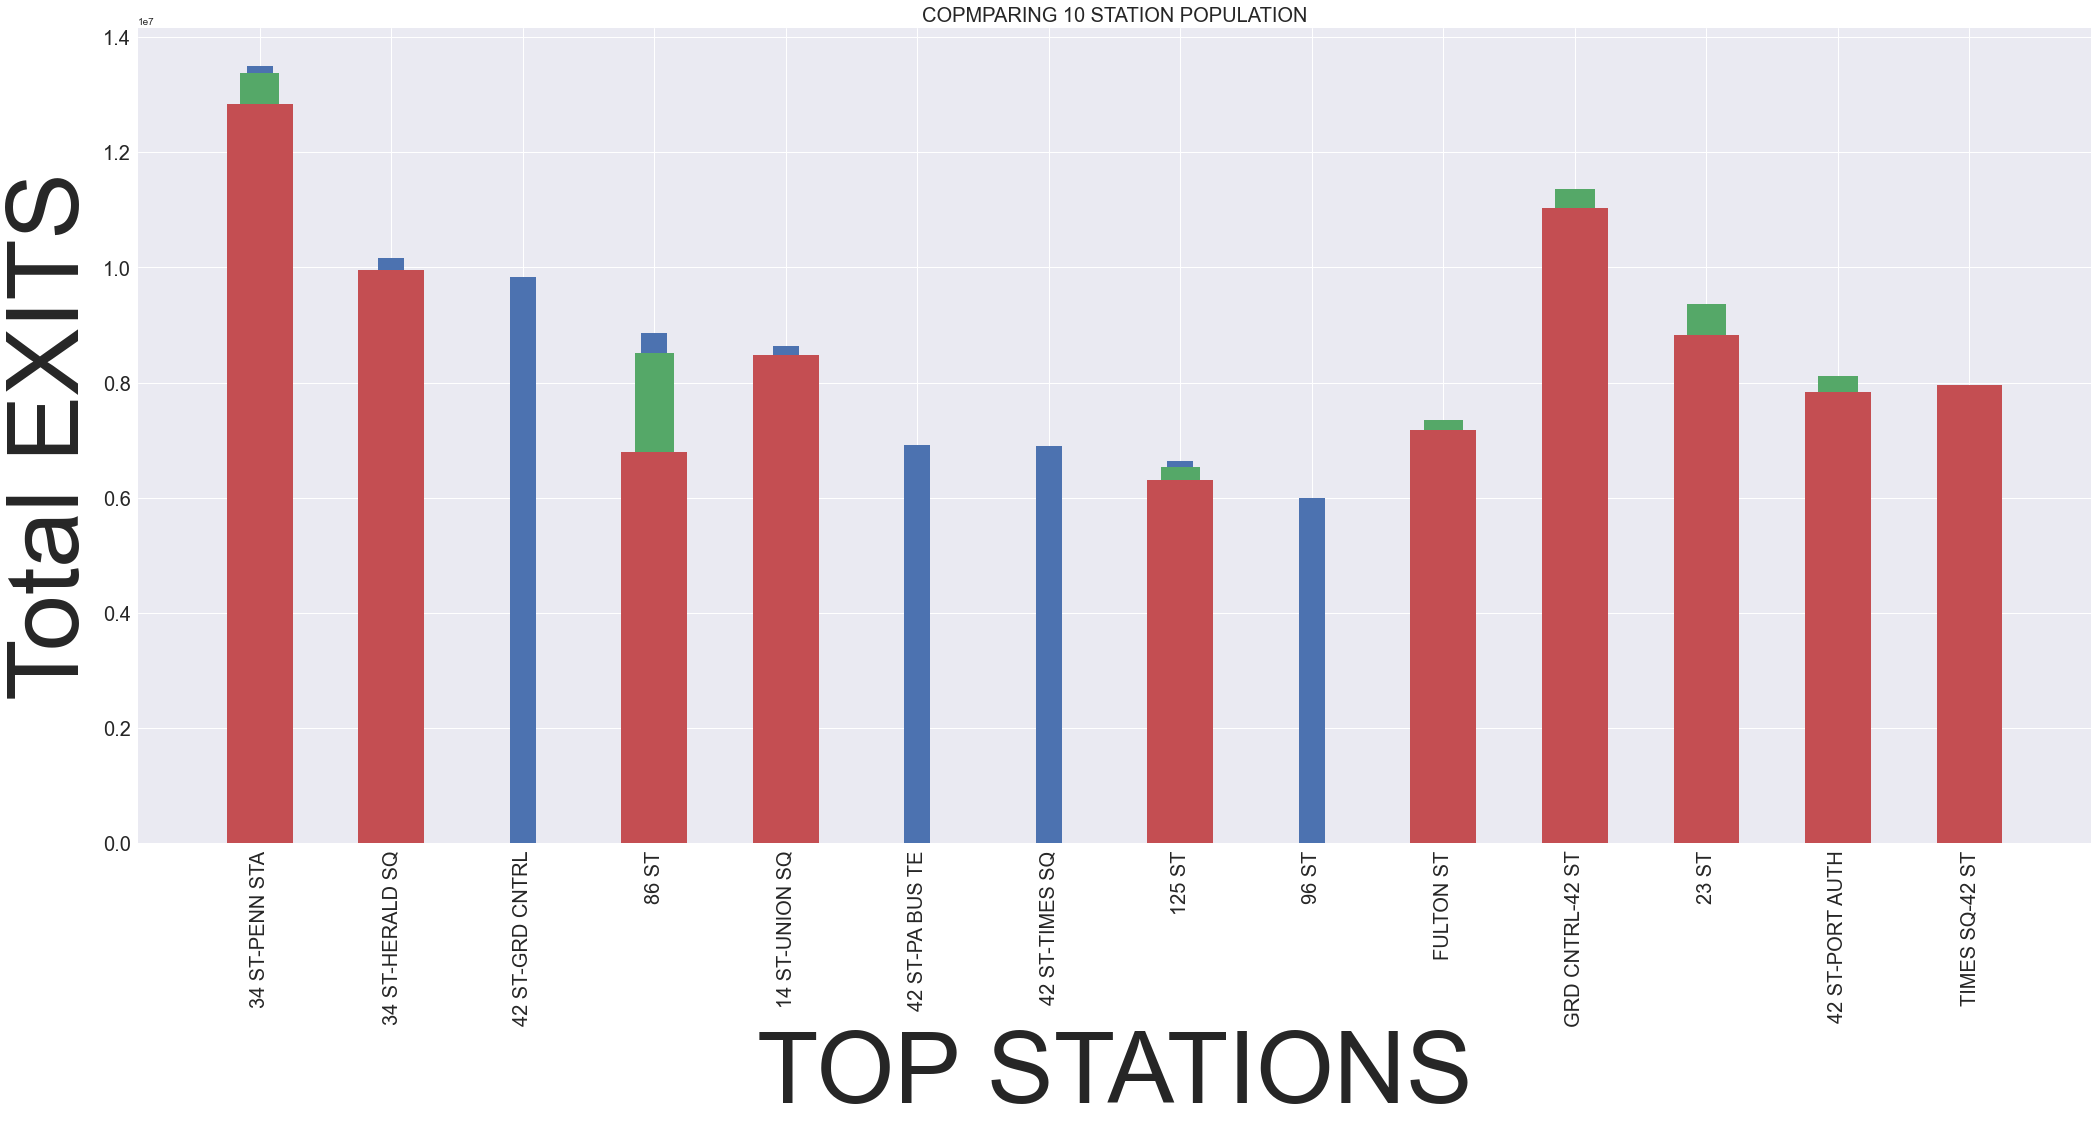

In [177]:
plt.figure(figsize=[35,15])
plt.bar(Year1.index, Year1.NET_ENTRIES, .2)
plt.bar(Year2.index, Year2.NET_ENTRIES, .3)
plt.bar(Year3.index, Year3.NET_ENTRIES, .5 )


plt.xlabel('TOP STATIONS',fontsize = 100)
plt.ylabel('Total EXITS', fontsize = 100)
plt.title('COPMPARING 10 STATION POPULATION',fontsize = 20 )
plt.xticks(rotation=90,fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)

No handles with labels found to put in legend.


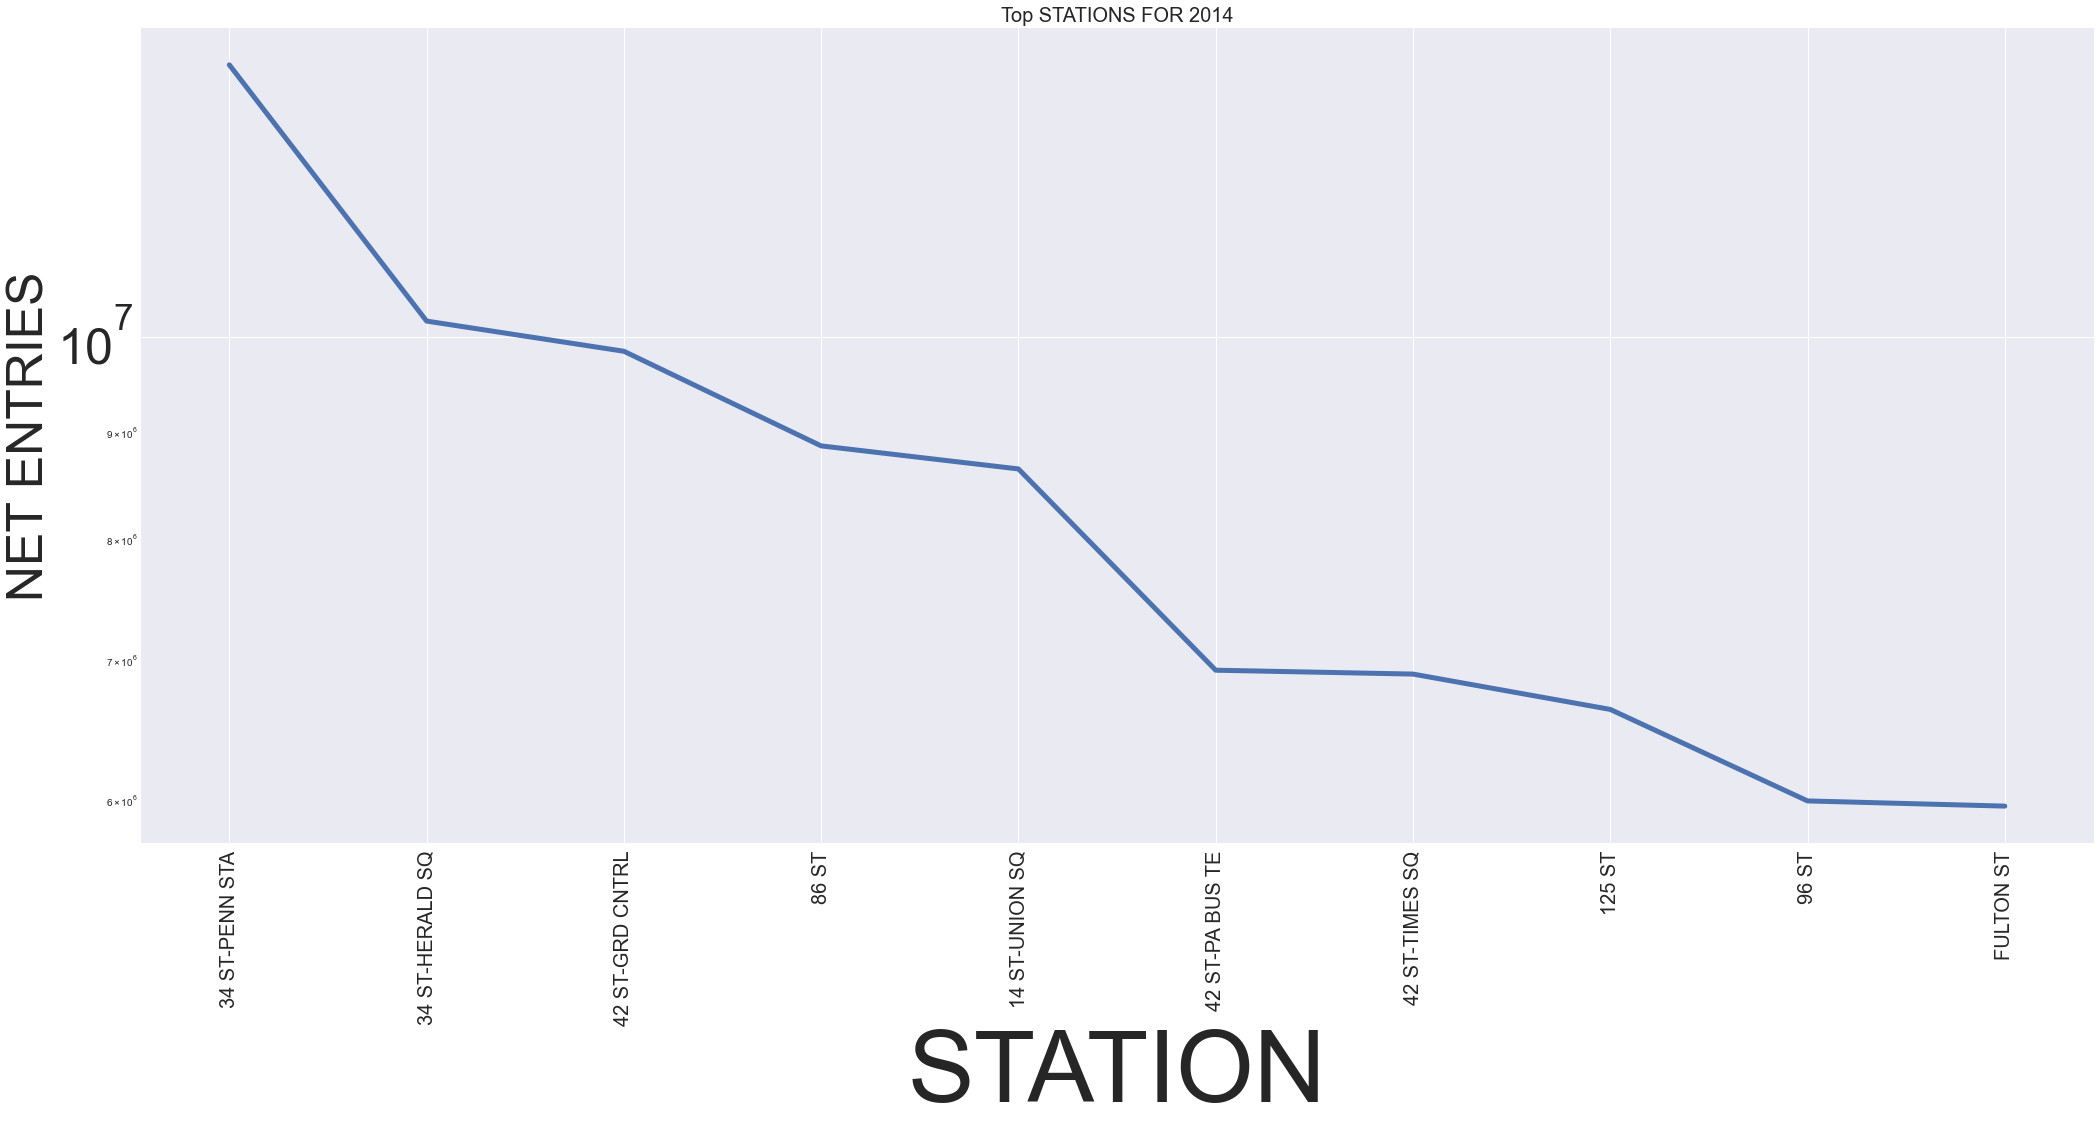

In [180]:
%matplotlib inline
plt.style.use('seaborn')

plt.figure(figsize=[35,15])

Year = ['2014','2015','2016','2017','2018','2019']
sns.lineplot(x= Year1.index, y = "NET_ENTRIES", data=Year1, linewidth = 5).set_yscale("log" )
#sns.lineplot(x= Year2.index, y = "NET_ENTRIES", data=Year1, linewidth = 5).set_yscale("log" )
#sns.lineplot(x= Year3.index, y = "NET_ENTRIES", data=Year1, linewidth = 5).set_yscale("log" )
#sns.lineplot(x= Year4.index, y = "NET_ENTRIES", data=Year1, linewidth = 5).set_yscale("log" )
#sns.lineplot(x= Year5.index, y = "NET_ENTRIES", data=Year1, linewidth = 5, hue = 'NET_EXITS').set_yscale("log" )

plt.xlabel(xlabel = 'STATION',fontsize = 100)

plt.ylabel(ylabel= 'NET ENTRIES', fontsize = 50)
plt.title('Top STATIONS FOR 2014',fontsize = 20 )
plt.xticks(rotation=90,fontsize = 20)
plt.yticks(fontsize = 50)
plt.legend(fontsize = 40)
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


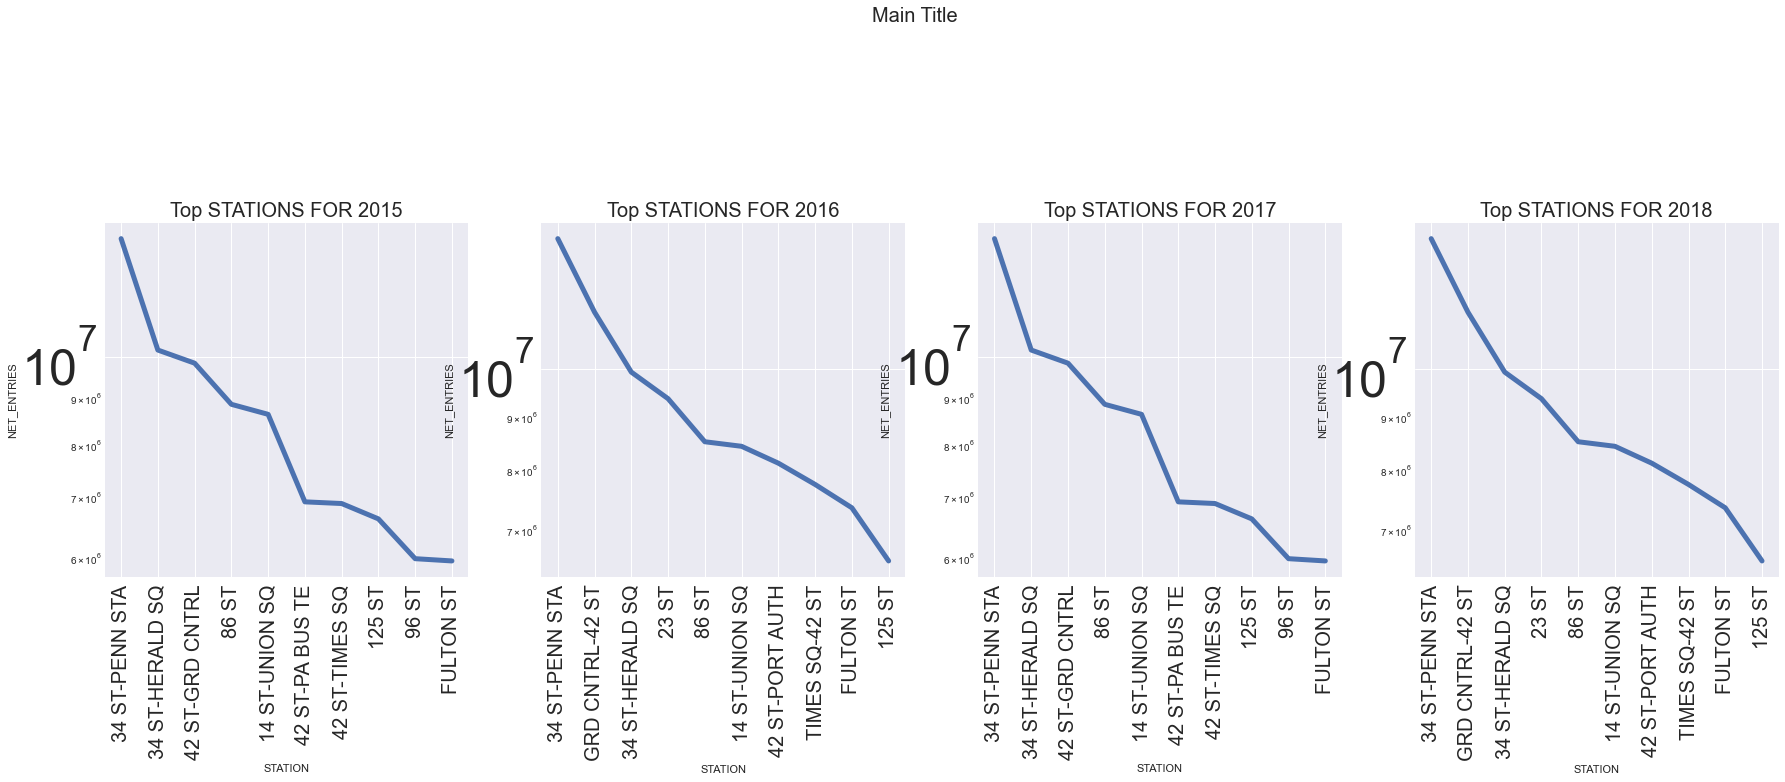

In [194]:
X = np.arange(20)
plt.figure(figsize=[30,30])

plt.suptitle('Main Title',fontsize = 20)

plt.subplot(4,4,1) # (number of rows, number of columns, number of plot)
sns.lineplot(x= Year1.index, y = "NET_ENTRIES", data=Year1, linewidth = 5).set_yscale("log" )
plt.title('Top STATIONS FOR 2015',fontsize = 20 )
plt.xticks(rotation=90,fontsize = 20)
plt.yticks(fontsize = 50)
plt.legend(fontsize = 40)

plt.subplot(4,4,2)
sns.lineplot(x= Year2.index, y = "NET_ENTRIES", data=Year2, linewidth = 5).set_yscale("log" )
plt.title('Top STATIONS FOR 2016',fontsize = 20 )
plt.xticks(rotation=90,fontsize = 20)
plt.yticks(fontsize = 50)
plt.legend(fontsize = 40)

plt.subplot(4,4,3) # (number of rows, number of columns, number of plot)
sns.lineplot(x= Year1.index, y = "NET_ENTRIES", data=Year1, linewidth = 5).set_yscale("log" )
plt.title('Top STATIONS FOR 2017',fontsize = 20 )
plt.xticks(rotation=90,fontsize = 20)
plt.yticks(fontsize = 50)
plt.legend(fontsize = 40)

plt.subplot(4,4,4)
sns.lineplot(x= Year2.index, y = "NET_ENTRIES", data=Year2, linewidth = 5).set_yscale("log" )
plt.title('Top STATIONS FOR 2018',fontsize = 20 )
plt.xticks(rotation=90,fontsize = 20)
plt.yticks(fontsize = 50)
plt.legend(fontsize = 40)

plt.savefig('plot2.jpg')
plt.show()

In [ ]:
%matplotlib inline
plt.style.use('seaborn')

plt.figure(figsize=[35,15])
x = range(5)
totIO = list(fst_AV_totIO.values)
tot_ents= list(fst_AV_tot_ents.values)
tot_exts=list(fst_AV_tot_exts.values)

w =0.2
bar1 = np.arange(15)
bar2 = [i+w for i in bar1]
bar3 = [j+w for j in bar2]

plt.bar(bar1,Year1.,w,label= 'total I/O')
plt.bar(bar2,tot_ents,w,label= 'total entries')
plt.bar(bar3,tot_exts,w,label= 'total exits')

In [137]:

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

plt.figure(figsize=[35,15])
x = Year1.index
Year1 = list(Year1.values)
Year2 = list(Year2.values)
Year3 = list(Year3.values)
Year4 = list(Year4.values)
Year5 = list(Year5.values)

w =0.1
bar1 = np.arange(10)
bar2 = [i+w for i in bar1]
bar3 = [j+w for j in bar2]
bar4 = [j+w for j in bar3]
bar5 = [j+w for j in bar4]


plt.bar(bar1,Year1,w,label= 'total I/O')
plt.bar(bar2,Year2,w,label= 'total entries')
plt.bar(bar3,Year3,w,label= 'total exits')
plt.bar(bar3,Year4,w,label= 'total exits')
plt.bar(bar3,Year5,w,label= 'total exits')

plt.xlabel('Dates',fontsize = 100)
plt.ylabel('Totals', fontsize = 100)
plt.title('1 AV STATION TOTAL IN AND OUTS VS TOTAL ENTRIES VS TOTAL EXIT FOR 1ST 15 DAYS',fontsize = 20 )
plt.xticks(bar2,x,rotation=90,fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)

#plt.savefig('plot1.jpg')
plt.show()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


NameError: name 'Year1' is not defined

<Figure size 2520x1080 with 0 Axes>

In [123]:
list(print(Year1))

[array([13492040., 11518498., 25010538.]), array([10173147.,  9069333., 19242480.]), array([ 9840242.,  8978988., 18819230.]), array([ 8865820.,  7259067., 16124887.]), array([ 8643465.,  7666383., 16309848.]), array([ 6924211.,  5133281., 12057492.]), array([ 6894764.,  6260437., 13155201.]), array([ 6631439.,  5104727., 11736166.]), array([ 5995360.,  4048001., 10043361.]), array([ 5961167.,  5073473., 11034640.])]


TypeError: 'NoneType' object is not iterable